# Tab Transformer

The TabTransformer (introduced [TabTransformer: Tabular Data Modeling Using Contextual Embeddings](https://arxiv.org/pdf/2012.06678.pdf)) is built upon self-attention based Transformers. The Transformer layers transform the embeddings of categorical features into robust contextual embeddings to achieve higher predictive accuracy.

The TabTransformer architecture works as follows:
* All the categorical features are encoded as embeddings, using the same embedding_dims. This means that each value in each categorical feature will have its own embedding vector.
* A column embedding, one embedding vector for each categorical feature, is added (point-wise) to the categorical feature embedding.
* The embedded categorical features are fed into a stack of Transformer blocks. Each Transformer block consists of a multi-head self-attention layer followed by a feed-forward layer.
* The outputs of the final Transformer layer, which are the contextual embeddings of the categorical features, are concatenated with the input numerical features, and fed into a final MLP block.
* A softmax classifer is applied at the end of the model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import joblib


# Data

In [2]:
data = pd.read_csv('../input/song-popularity-prediction/train.csv')
print(data.shape)
data.head()

(40000, 15)


,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [3]:
test = pd.read_csv('../input/song-popularity-prediction/test.csv')
X_test = test.drop(['id'], axis=1)

In [4]:
X = data.drop(['id', 'song_popularity'], axis=1)
y = data['song_popularity']

In [5]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Model

In [6]:
class TabularNetworkConfig():
    def __init__(
        self, 
        target_feature_name, 
        target_feature_labels, 
        numeric_feature_names, 
        categorical_features_with_vocabulary,
        num_outputs,
        out_activation,
        num_transformer_blocks, 
        num_heads,
        embedding_dim,
        mlp_hidden_units_factors,
        dropout_rate,
        use_column_embedding,
    ):
        self.TARGET_FEATURE_NAME = target_feature_name
        self.TARGET_FEATURE_LABELS = target_feature_labels
        self.NUMERIC_FEATURE_NAMES = numeric_feature_names
        self.CATEGORICAL_FEATURES_WITH_VOCABULARY = categorical_features_with_vocabulary
        self.CATEGORICAL_FEATURE_NAMES = list(self.CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
        self.FEATURE_NAMES = self.NUMERIC_FEATURE_NAMES + self.CATEGORICAL_FEATURE_NAMES
        self.NUM_OUT = num_outputs
        self.OUT_ACTIVATION = out_activation
        self.NUM_TRANSFORMER_BLOCKS = num_transformer_blocks
        self.NUM_HEADS = num_heads
        self.EMBEDDING_DIM = embedding_dim
        self.MLP_HIDDEN_UNITS_FACTORS = mlp_hidden_units_factors
        self.DROPOUT_RATE = dropout_rate
        self.USE_COLUMN_EMBEDDING = use_column_embedding
        

class BaseTabularNetwork():
    @staticmethod
    def get_inputs(config):
        return {
        feature_name: L.Input(
            name=feature_name,
            shape=(),
            dtype=(tf.float32 if feature_name in config.NUMERIC_FEATURE_NAMES else tf.string),
        )
        for feature_name in config.FEATURE_NAMES
    }
    
    @staticmethod
    def encode_inputs(inputs, config, prefix=''):
        cat_features = []
        num_features = []
        for feature_name in inputs:
            if feature_name in config.CATEGORICAL_FEATURE_NAMES:
                vocabulary = config.CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
                lookup = L.StringLookup(
                    vocabulary=vocabulary,
                    mask_token=None,
                    num_oov_indices=0,
                    output_mode="int",
                    name=f"{prefix}{feature_name}_lookup"
                )
                encoded_feature = lookup(inputs[feature_name])
                embedding = L.Embedding(
                    input_dim=len(vocabulary), output_dim=config.EMBEDDING_DIM,
                    name=f"{prefix}{feature_name}_embeddings"
                )
                encoded_feature = embedding(encoded_feature)
                cat_features.append(encoded_feature)
            else:
                encoded_feature = L.Reshape((1, ), name=f"{prefix}{feature_name}_reshape")(inputs[feature_name])
                num_features.append(encoded_feature)

        return cat_features, num_features

In [7]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(L.Dense(units, activation=activation))
        mlp_layers.append(L.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

In [8]:
class TabTransformer(BaseTabularNetwork):
    @classmethod
    def from_config(cls, name, config):
        inputs = cls.get_inputs(config)
        cat_features, num_features = cls.encode_inputs(inputs, config)
        
        cat_features = tf.stack(cat_features, axis=1)
        num_features = L.concatenate(num_features)
        
        if config.USE_COLUMN_EMBEDDING:
            num_columns = cat_features.shape[1]
            column_embedding = L.Embedding(
                input_dim=num_columns, output_dim=config.EMBEDDING_DIM
            )
            column_indices = tf.range(start=0, limit=num_columns, delta=1)
            cat_features = cat_features + column_embedding(column_indices)
        
        for block_idx in range(config.NUM_TRANSFORMER_BLOCKS):
            attention_output = L.MultiHeadAttention(
                num_heads=config.NUM_HEADS,
                key_dim=config.EMBEDDING_DIM,
                dropout=config.DROPOUT_RATE,
                name=f"multihead_attention_{block_idx}",
            )(cat_features, cat_features)
            x = L.Add(name=f"skip_connection1_{block_idx}")([attention_output, cat_features])
            x = L.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
            feedforward_output = create_mlp(
                hidden_units=[config.EMBEDDING_DIM],
                dropout_rate=config.DROPOUT_RATE,
                activation=keras.activations.gelu,
                normalization_layer=L.LayerNormalization(epsilon=1e-6),
                name=f"feedforward_{block_idx}",
            )(x)
            x = L.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
            cat_features = L.LayerNormalization(name=f"layer_norm2_{block_idx}", epsilon=1e-6)(x)
        
        cat_features = L.Flatten()(cat_features)
        num_features = L.LayerNormalization(epsilon=1e-6)(num_features)
        features = L.concatenate([cat_features, num_features])
        mlp_hidden_units = [factor * features.shape[-1] for factor in config.MLP_HIDDEN_UNITS_FACTORS]
        features = create_mlp(
            hidden_units=mlp_hidden_units,
            dropout_rate=config.DROPOUT_RATE,
            activation=keras.activations.selu,
            normalization_layer=L.BatchNormalization(),
            name="MLP",
        )(features)
        
        outputs = L.Dense(units=config.NUM_OUT, activation=config.OUT_ACTIVATION, name="outputs")(features)
        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        return model

In [9]:
model_config = TabularNetworkConfig(
    target_feature_name="song_popularity", 
    target_feature_labels=["0", "1"], 
    numeric_feature_names=[
        'song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
        'speechiness', 'tempo', 'audio_valence'
    ], 
    categorical_features_with_vocabulary={
        'key': list(map(str, range(12))),
        'audio_mode': ["0", "1"],
        'time_signature': ["2", "3", "4", "5"]   
    },
    num_outputs=1,
    out_activation="sigmoid",
    num_transformer_blocks=3, 
    num_heads=4,
    embedding_dim=32,
    mlp_hidden_units_factors=[2, 1],
    dropout_rate=0.2,
    use_column_embedding=True,
)

MAX_EPOCHS  = 250

get_callbacks = lambda : [
    keras.callbacks.EarlyStopping(min_delta=1e-4, patience=10, verbose=1, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
]


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

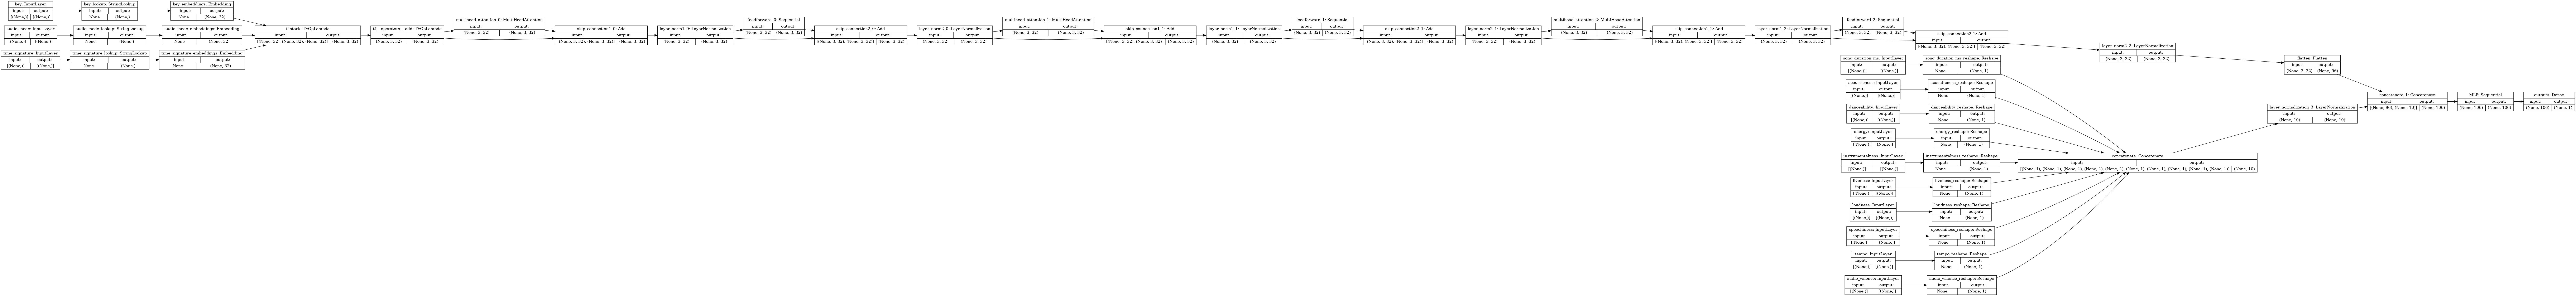

In [10]:
keras.utils.plot_model(
    TabTransformer.from_config("tab_transformer", model_config),
    show_shapes=True, rankdir="LR", to_file="tab_transformer.png"
)

# Training

In [11]:
preds = []

for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    mean_imputer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler())
    ]).fit(X_train[model_config.NUMERIC_FEATURE_NAMES])
    mode_imputer = SimpleImputer(strategy='most_frequent').fit(X_train[model_config.CATEGORICAL_FEATURE_NAMES])
    
    X_train = pd.concat([
        pd.DataFrame(
            mean_imputer.transform(X_train[model_config.NUMERIC_FEATURE_NAMES]), 
            columns=model_config.NUMERIC_FEATURE_NAMES
        ),
        pd.DataFrame(
            mode_imputer.transform(X_train[model_config.CATEGORICAL_FEATURE_NAMES]).astype(float).astype(int), 
            columns=model_config.CATEGORICAL_FEATURE_NAMES
        ).astype(str),
    ], axis=1)
    X_valid = pd.concat([
        pd.DataFrame(
            mean_imputer.transform(X_valid[model_config.NUMERIC_FEATURE_NAMES]), 
            columns=model_config.NUMERIC_FEATURE_NAMES
        ),
        pd.DataFrame(
            mode_imputer.transform(X_valid[model_config.CATEGORICAL_FEATURE_NAMES]).astype(float).astype(int), 
            columns=model_config.CATEGORICAL_FEATURE_NAMES
        ).astype(str),
    ], axis=1)
    X_test_ = pd.concat([
        pd.DataFrame(
            mean_imputer.transform(X_test[model_config.NUMERIC_FEATURE_NAMES]), 
            columns=model_config.NUMERIC_FEATURE_NAMES
        ),
        pd.DataFrame(
            mode_imputer.transform(X_test[model_config.CATEGORICAL_FEATURE_NAMES]).astype(float).astype(int), 
            columns=model_config.CATEGORICAL_FEATURE_NAMES
        ).astype(str),
    ], axis=1)
        
    data_train = tf.data.Dataset.from_tensor_slices((
    {col: X_train[col].values.tolist() for col in model_config.FEATURE_NAMES}, 
        y_train.values.tolist()
    )).batch(1024)
    data_valid = tf.data.Dataset.from_tensor_slices((
        {col: X_valid[col].values.tolist() for col in model_config.FEATURE_NAMES}, 
        y_valid.values.tolist()
    )).batch(1024)
    data_test = tf.data.Dataset.from_tensor_slices((
        {col: X_test_[col].values.tolist() for col in model_config.FEATURE_NAMES}
    )).batch(1024)
    
    model = TabTransformer.from_config("deep_network", model_config)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.fit(data_train, validation_data=data_valid, callbacks=get_callbacks(), epochs=MAX_EPOCHS)  
    preds.append(model.predict(data_test))

Epoch 1/250


2022-01-21 17:52:54.445299: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


36/36 [==============================] - 12s 152ms/step - loss: 0.7648 - accuracy: 0.5631 - val_loss: 0.6521 - val_accuracy: 0.6332
Epoch 2/250
36/36 [==============================] - 4s 121ms/step - loss: 0.7052 - accuracy: 0.5852 - val_loss: 0.6533 - val_accuracy: 0.6357
Epoch 3/250
36/36 [==============================] - 4s 122ms/step - loss: 0.6897 - accuracy: 0.5964 - val_loss: 0.6519 - val_accuracy: 0.6357
Epoch 4/250
36/36 [==============================] - 4s 123ms/step - loss: 0.6808 - accuracy: 0.6026 - val_loss: 0.6524 - val_accuracy: 0.6338
Epoch 5/250
36/36 [==============================] - 4s 121ms/step - loss: 0.6756 - accuracy: 0.6105 - val_loss: 0.6514 - val_accuracy: 0.6363
Epoch 6/250
36/36 [==============================] - 4s 122ms/step - loss: 0.6710 - accuracy: 0.6126 - val_loss: 0.6519 - val_accuracy: 0.6363
Epoch 7/250
36/36 [==============================] - 4s 123ms/step - loss: 0.6665 - accuracy: 0.6187 - val_loss: 0.6524 - val_accuracy: 0.6365
Epoch 8/25

# Submissions

In [12]:
submissions = pd.read_csv('../input/song-popularity-prediction/sample_submission.csv')
submissions['song_popularity'] = np.array(preds).mean(axis=0)
submissions.to_csv('preds.csv', index=False)